# Load Forecasting

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import openml
from torch.utils.data import Dataset, DataLoader


In [2]:
df = openml.datasets.get_dataset(46340)
df, _, _, _ = df.get_data()
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,date,temp,wind,sun,Load,Instant,Posan,JourSemaine,JourFerie,offset,DayType,Weekend,temp_liss_fort,temp_liss_faible,tempMax,tempMin
0,2017-01-01T00:00:00Z,-1.940235,1.968498,0.0,15052349,2,0.000114,0,1,20,30,1,-0.750143,3.375117,2.814086,-2.120351
1,2017-01-01T00:30:00Z,-1.969982,1.977643,0.0,17580789,3,0.000171,0,1,20,30,1,-0.784298,3.359082,2.814086,-2.120351
2,2017-01-01T01:00:00Z,-1.999729,1.986789,0.0,19854004,4,0.000228,0,1,20,30,1,-0.818330,3.343006,2.814086,-2.120351
3,2017-01-01T01:30:00Z,-2.043080,1.987839,0.0,18741368,5,0.000285,0,1,20,30,1,-0.852623,3.326847,2.814086,-2.120351
4,2017-01-01T02:00:00Z,-2.086432,1.988890,0.0,17859804,6,0.000342,0,1,20,30,1,-0.887170,3.310607,2.814086,-2.120351


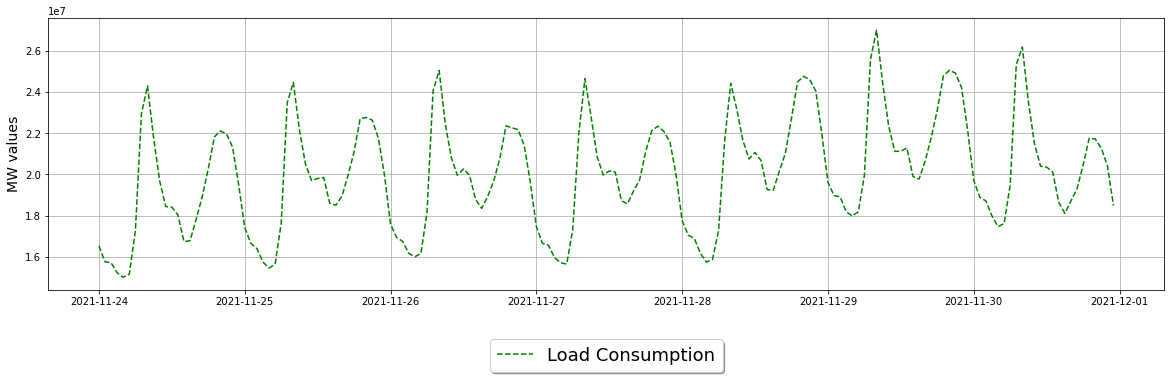

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
df['date']= pd.to_datetime(df['date'])
df.set_index("date", inplace=True)
df = df[df.index.minute==0]

df_plot = df[(df.index.year == 2021)&(df.index.month==11)&(df.index.day>23)]
plt.plot(df_plot.index, df_plot['Load'], '--', c='g', label='Load Consumption')

plt.grid()
plt.ylabel('MW values', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, fontsize="18") 
plt.show()

In [4]:
df_train = df[df.index.year<2020]
df_val = df[df.index.year==2021]
df_test = df[df.index.year==2022]

X_train = df_train.drop('Load', axis=1)
X_val = df_val.drop('Load', axis=1)
X_test = df_test.drop('Load', axis=1)

max_X = X_train.max(axis=0)*1.1
min_X = X_train.min(axis=0)*0.9
X_train = (X_train - min_X)/(max_X - min_X)
X_val = (X_val - min_X)/(max_X - min_X)
X_test = (X_test - min_X)/(max_X - min_X)

y_train = df_train[['Load']]
y_val = df_val[['Load']]
y_test = df_test[['Load']]

max_y = (y_train.max(axis=0)*1.1).item()
min_y = (y_train.min(axis=0)*0.9).item()
print(f"Training period: ({X_train.shape} | {y_train.shape}), val period: ({X_val.shape} | {y_val.shape}), test period: (({X_test.shape} | {y_test.shape}))")

Training period: ((26280, 14) | (26280, 1)), val period: ((8760, 14) | (8760, 1)), test period: (((8760, 14) | (8760, 1)))


In [5]:
class LoadDataset(Dataset):
    def __init__(self, X,y, min_y, max_y):
        self.X = X
        self.y = y
        self.dates = pd.unique(X.index.date)
        self.min_y = min_y
        self.max_y = max_y

    def __getitem__(self, index):
        idx = str(self.dates[index])
        x = self.X.loc[idx].values
        y = ((self.y.loc[idx] - self.min_y)/(self.max_y - self.min_y)).values.squeeze()
        return np.expand_dims(x, -1),y
    
    def denormalize(self, y):
        df = pd.DataFrame(index=self.X.index)
        df['Pred'] = y*(self.max_y - self.min_y) + self.min_y
        return df
    
    def __len__(self):
        return self.dates.shape[0]
    
train_set = LoadDataset(X_train, y_train, min_y, max_y)
val_set = LoadDataset(X_val, y_val, min_y, max_y)
test_set = LoadDataset(X_test, y_test, min_y, max_y)

train_loader = DataLoader(train_set, batch_size=64, shuffle=False)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [6]:
class LoadModel(nn.Module):
    def __init__(self, args, ts_shape):
        super().__init__()
        self.args = args
        self.input_shape = ts_shape

        # 2-dimensional DAG
        self.cell_2d = args['2D Dag']
        self.cell_2d.set(self.input_shape)

        # Compute after flatten
        self.flat_shape = (self.cell_2d.output_shape[0],np.prod(self.cell_2d.output_shape[1:]))

        # 1-dimensional DAG
        self.cell_1d = args['1D Dag']
        self.cell_1d.set(self.flat_shape)

        # Output layer
        self.output = args["Out"]
        args['Out'].set(self.cell_1d.output_shape)

    def forward(self, X):
        out_2d = self.cell_2d(X)
        flat = nn.Flatten(start_dim=2)(out_2d)
        out_1d = self.cell_1d(flat)
        out = self.output(out_1d)
        return out.squeeze(-1)
    
    def set_prediction_to_save(self, name, df):
        self.prediction = {name: df}
    
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        full_path = os.path.join(path, "best_model.pth")
        torch.save(self.state_dict(), full_path)
        if hasattr(self, "prediction"):
            for k in self.prediction.keys():
                self.prediction[k].to_csv(os.path.join(path, f"best_model_{k}_outputs.csv"))

In [7]:
from dragon.search_space.bricks_variables import mlp_var, dropout, identity_var, mlp_const_var, conv_1d, conv_2d, pooling_1d, pooling_2d, attention_1d, attention_2d, norm_1d, norm_2d
from dragon.search_space.bricks_variables import operations_var, dag_var, node_var
from dragon.search_space.zellij_variables import ArrayVar
from dragon.search_algorithm.zellij_neighborhoods import ArrayInterval

candidate_operations_2d = operations_var("2D Candidate operations", size=5, 
                                            candidates=[identity_var("Unitary"), attention_2d("Attention"), mlp_var("MLP"), conv_2d("Convolution", 24), 
                                                        pooling_2d('Pooling'), norm_2d("Norm"), dropout('Dropout')])

dag_2d = dag_var("2D Dag", candidate_operations_2d)

candidate_operations_1d = operations_var("2D Candidate operations", size=5, 
                                            candidates=[identity_var("Unitary"), attention_1d("Attention"), mlp_var("MLP"), conv_1d("Convolution", 24), 
                                                        pooling_1d('Pooling'), norm_1d("Norm"), dropout('Dropout')])
dag_1d = dag_var("1D Dag", candidate_operations_1d)
out = node_var("Out", operation=mlp_const_var('Operation', 1), activation_function=nn.Identity())

search_space = ArrayVar(dag_2d, dag_1d, out, label="Search Space", neighbor=ArrayInterval())
labels = [e.label for e in search_space]

In [9]:
def MSE(actual, pred):
    return np.mean((actual - pred) ** 2)


def MAPE(actual, pred):
    return np.mean(np.abs((actual - pred) / actual))


def RMSE(actual, pred):
    return np.sqrt(MSE(actual, pred))

def train_model(model, data_loader, verbose=False):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
    model.train()
    for ep in range(20):
        ep_loss = 0
        for X,y in data_loader:
            optimizer.zero_grad()
            X, y = X.float(), y.float()
            pred = model(X)
            loss = loss_fn(pred,y)
            loss.backward()
            optimizer.step()
            ep_loss += loss
        if verbose:
            print(f"Train | Epoch: {ep}, loss = {ep_loss / len(data_loader)}")
    return model

def test_model(model, data_loader):
    loss_fn = nn.MSELoss()
    model.eval()
    test_loss = 0
    preds = []
    trues = []
    with torch.no_grad():
      for X, y in data_loader:
          X, y = X.float(), y.float()
          pred = model(X)
          loss = loss_fn(pred, y).item()
          test_loss += loss
          preds.append(pred.detach().numpy())
          trues.append(y.detach().numpy())
    loss = test_loss / len(data_loader)
    return loss, preds, trues

def loss_function(args, idx, verbose=False):
    args = dict(zip(labels, args))
    model = LoadModel(args, train_set.__getitem__(0)[0].shape)
    model = train_model(model, train_loader, verbose=verbose)
    loss, preds, trues = test_model(model, val_loader)
    preds = np.concatenate((np.asarray(preds[:-1]).reshape(-1,1), np.asarray(preds[-1]).reshape(-1,1)))
    trues = np.concatenate((np.asarray(trues[:-1]).reshape(-1,1), np.asarray(trues[-1]).reshape(-1,1)))
    preds = val_set.denormalize(preds)
    trues = val_set.denormalize(trues)
    mape = MAPE(trues, preds)
    rmse = RMSE(trues, preds)
    print(f"Idx: {idx}, on validation set: MAPE = {mape}, RMSE = {rmse}")
    return loss, model

args = search_space.random()
loss, model = loss_function(args, 0, verbose=True)
print(f'For a given argument, loss = {loss}')

In [ ]:
from dragon.search_algorithm.ssea import SteadyStateEA

search_algorithm = SteadyStateEA(search_space, n_iterations=20, population_size=5, selection_size=3, evaluation = loss_function, save_dir="save/test_load")
min_loss = search_algorithm.run()